In [ ]:
import scanpy as sc
import squidpy as sq
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *
import os
from ipylab import JupyterFrontEnd
from algorithms_torch import *
from data_gen import *
from datasets import *
import time
import torch
torch.cuda.get_device_name()

'NVIDIA RTX A5000'

In [ ]:
def filter_general_topology_torch(A, V, regu=0.5, iterNum=300):
    A = cell_normalization(A)
    F = torch.ones(A.shape)
    V =torch.from_numpy(V)
    A =torch.from_numpy(A)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    A = A.to(device)
    V = V.to(device)
    VVT = (V).mm(V.T)
    del V
    torch.cuda.empty_cache()
    F = F.to(device)
    print(A.get_device())
    print(device)
    print("starting filtering")
    F = gradient_descent_full_torch(A,F=F,VVT=VVT,regu=regu,epsilon=0.1,iterNum=iterNum , device=device)
    return F


In [ ]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.slideseqv2()
adata

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.19.5 scipy==1.7.3 pandas==1.2.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
squidpy==1.1.0


AnnData object with n_obs × n_vars = 41786 × 4000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
adata = sc.pp.subsample(adata, fraction=0.7, copy=True)

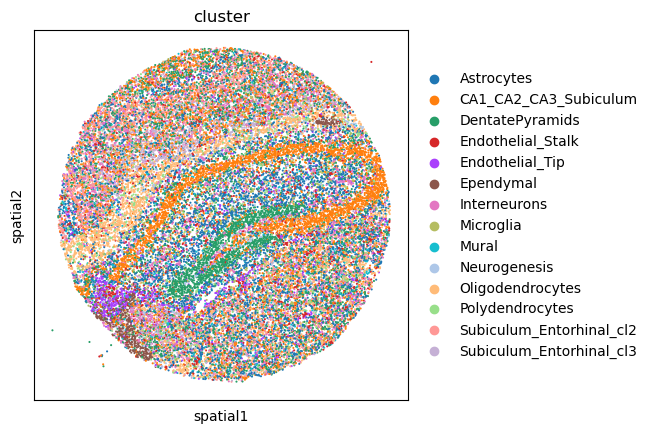

In [ ]:
sc.pl.spatial(adata, color="cluster", spot_size=30)

In [ ]:
sq.gr.spatial_neighbors(adata, n_rings=3, coord_type="grid" , n_neigh=20)



/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
A = adata.obsp["spatial_connectivities"]
B = A.toarray()

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall


graph = csr_matrix(B)
dist_matrix =  shortest_path(csgraph=graph, directed=False, return_predecessors=False)

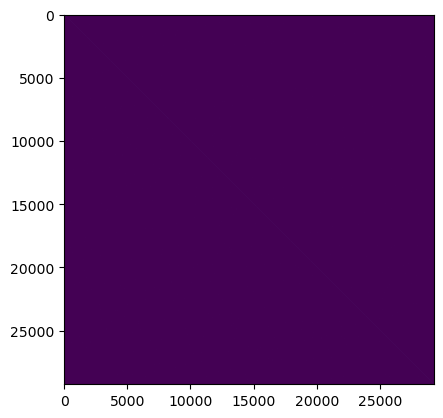

In [ ]:
D = np.exp(-dist_matrix)
plt.imshow(D)

/cs/labs/mornitzan/karinjo/scPrisma_revision/spectrum_gen.py:265: RuntimeWarning: invalid value encountered in sqrt
  eig_vecs[:, i] *= np.sqrt(eig_vals[i])


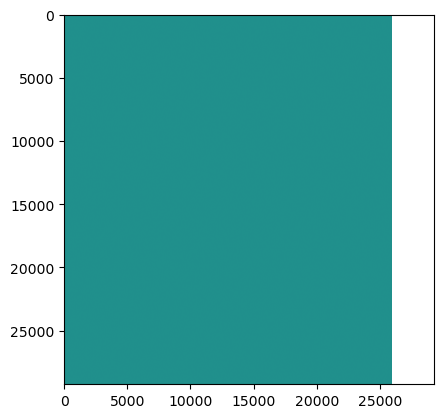

In [ ]:
VT = get_theoretic_eigen(D)
plt.imshow(VT)

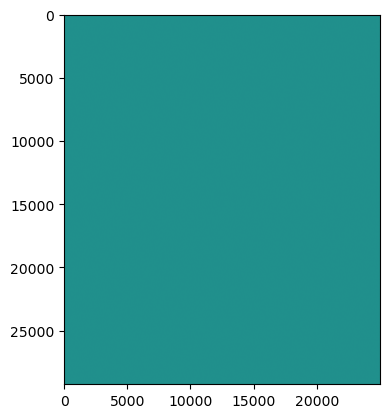

In [ ]:
VT=VT[:,:25000]
plt.imshow(VT)

In [ ]:
orig_adata = adata.copy()
D =gene_inference_general_topology_torch(np.array(adata.X.toarray()).astype('float64'), VT, regu=1, iterNum=50 )

Iteration number: 
1
Iteration number: 
26
torch.cuda.memory_allocated: 7.313558GB


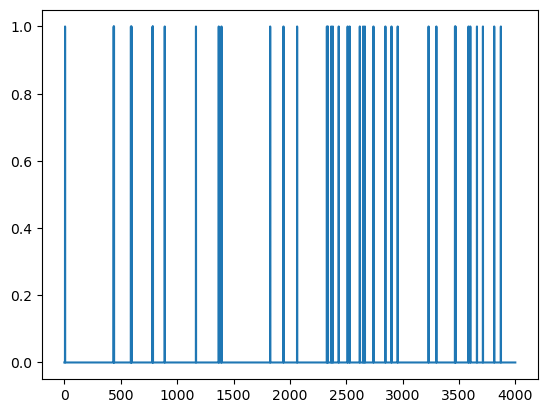

In [ ]:
plt.plot(D.diagonal().cpu())
D = D.cpu()
D = D.numpy()

In [ ]:
adata_genes_inference = orig_adata.copy()
adata_genes_inference.X = (adata_genes_inference.X.toarray()).dot(D)

In [ ]:
sc.pp.filter_genes(adata_genes_inference, min_counts=25)
adata_genes_inference

AnnData object with n_obs × n_vars = 29250 × 39
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [ ]:
F =enhance_general_topology_torch(adata_genes_inference.X, VT, regu=3, iterNum=250 )

0
cuda
starting filtering
Iteration number: 1
Iteration number: 101
Iteration number: 201
torch.cuda.memory_allocated: 7.279082GB


In [ ]:
adata_enhanced= adata_genes_inference.copy()
adata_enhanced.X = adata_enhanced.X *F.cpu().numpy()

In [ ]:
adata_filtered = orig_adata.copy()
F1 =filter_general_topology_torch(np.array(adata_filtered.X.toarray()).astype('float64'), VT, regu=0, iterNum=250 )

0
cuda
starting filtering
Iteration number: 1
Iteration number: 101
Iteration number: 201
torch.cuda.memory_allocated: 9.439744GB


In [ ]:
adata_filtered.X =  (adata_filtered.X.toarray()) * (F1.cpu().numpy())


In [ ]:
sq.gr.spatial_autocorr(orig_adata, mode="moran")
orig_adata.uns["moranI"].head(5)

I  pval_norm  var_norm  pval_norm_fdr_bh
Ttr    0.689246        0.0  0.000003               0.0
Hpca   0.478075        0.0  0.000003               0.0
Mbp    0.436531        0.0  0.000003               0.0
Enpp2  0.423435        0.0  0.000003               0.0
Plp1   0.403143        0.0  0.000003               0.0

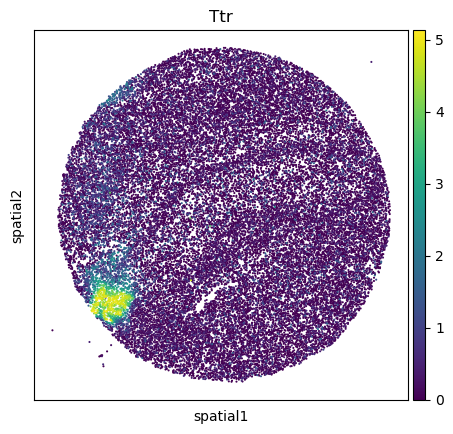

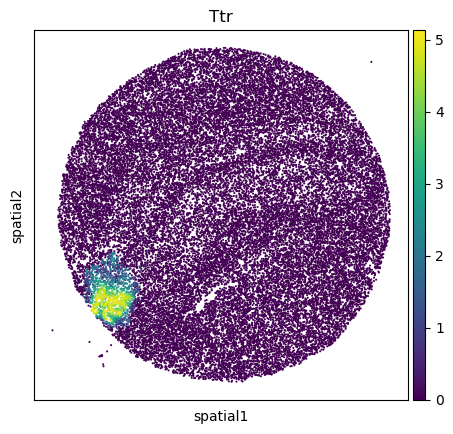

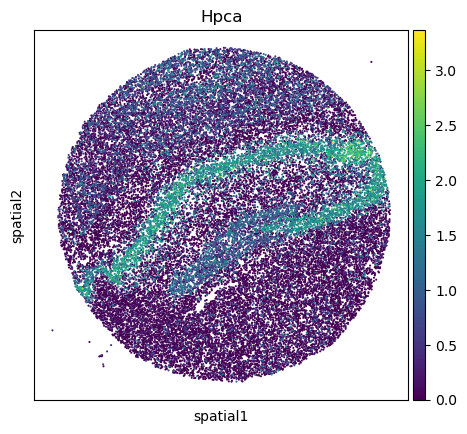

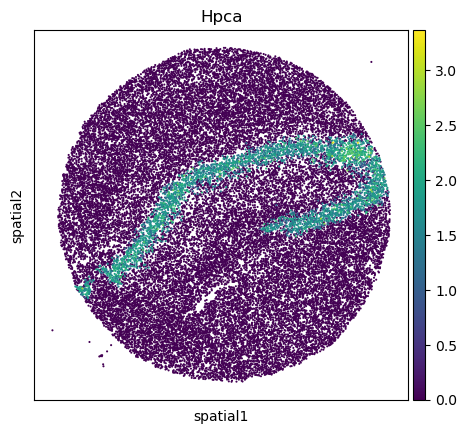

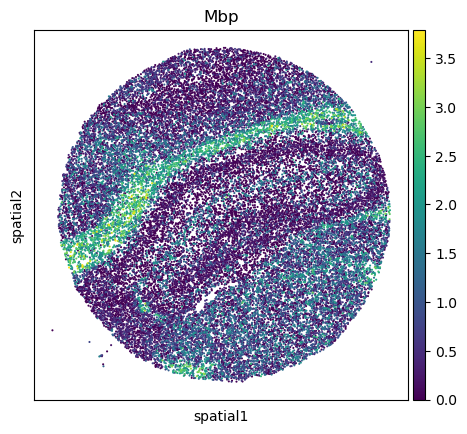

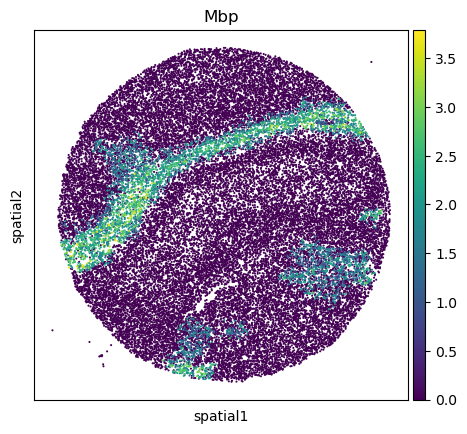

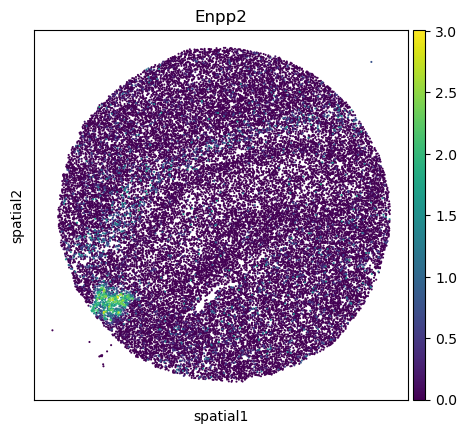

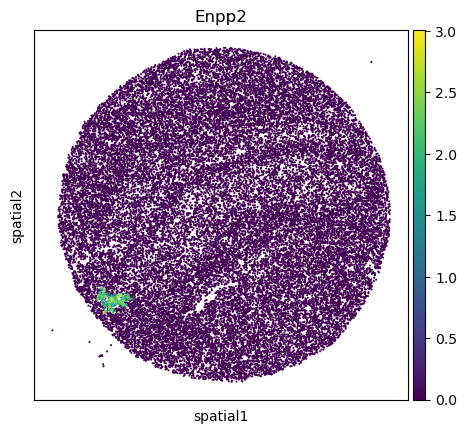

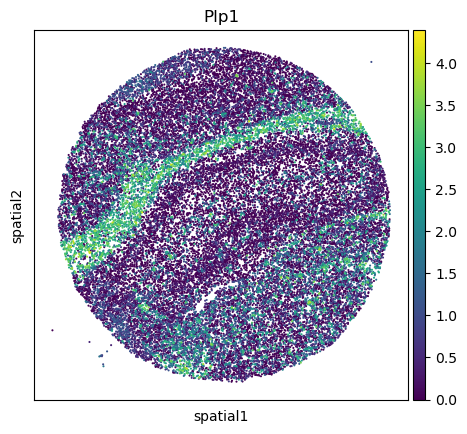

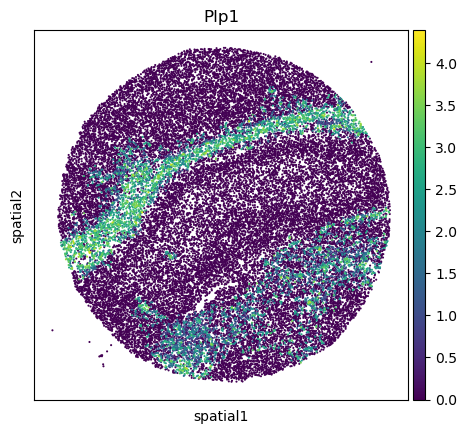

In [ ]:
genes_list =['Ttr','Hpca','Mbp','Enpp2','Plp1']
for i in genes_list:
    sc.pl.spatial(adata_genes_inference, color=i, spot_size=30)
    sc.pl.spatial(adata_enhanced, color=i, spot_size=30 , use_raw=False)

In [ ]:
adata7= adatac.copy()
adata7.X = adata7.X *F1.cpu().numpy()
